# Loan Default Prediction
### Hubert, Kevin, Joseph, Ankita
### About
This is our final project for ECS111. Our goal is to create a model that can accurately and efficiently predict whether someone will default their loan, utilizing information from their credit history and other metrics

### Dataset
The data is collected through an online Kaggle Competition [shown here](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)

'ID': client number
 'CODE_GENDER': gender 
 'FLAG_OWN_CAR': has car? 
 'FLAG_OWN_REALTY': property? 
 'CNT_CHILDREN': number of children
 'AMT_INCOME_TOTAL': annual income 
 'NAME_INCOME_TYPE': type of income 
 'NAME_EDUCATION_TYPE': education level
 'NAME_FAMILY_STATUS': marital status 
 'NAME_HOUSING_TYPE': way of living
 'DAYS_BIRTH': birthday?????
 'DAYS_EMPLOYED': start date?????
 'FLAG_MOBIL': has mobile phone? 
 'FLAG_WORK_PHONE': has work phone?
 'FLAG_PHONE': has phone?
 'FLAG_EMAIL': has email? 
 'OCCUPATION_TYPE': occupation 
 'CNT_FAM_MEMBERS':family size

In [696]:
# import packages
# processing
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer,make_column_transformer
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

#system
import os

In [697]:
# load data
application_records = pd.read_csv('application_record.csv.zip',compression='zip')
credit_records = pd.read_csv('credit_record.csv.zip',compression='zip')

In [698]:
application_records.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [699]:
application_records.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [700]:
credit_records.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [701]:
one = application_records['ID'].unique()

In [702]:
two = credit_records['ID'].unique()

In [703]:
difference = np.setdiff1d(two,one)
print(difference)

[5001711 5001712 5001713 ... 5122363 5122364 5122365]


In [704]:
len(difference)

9528

In [705]:
#'ID': client number
#'MONTHS_BALANCE': record months, 
#'STATUS':
# C means loan is closed or paid off
# X means no loan for the month
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days

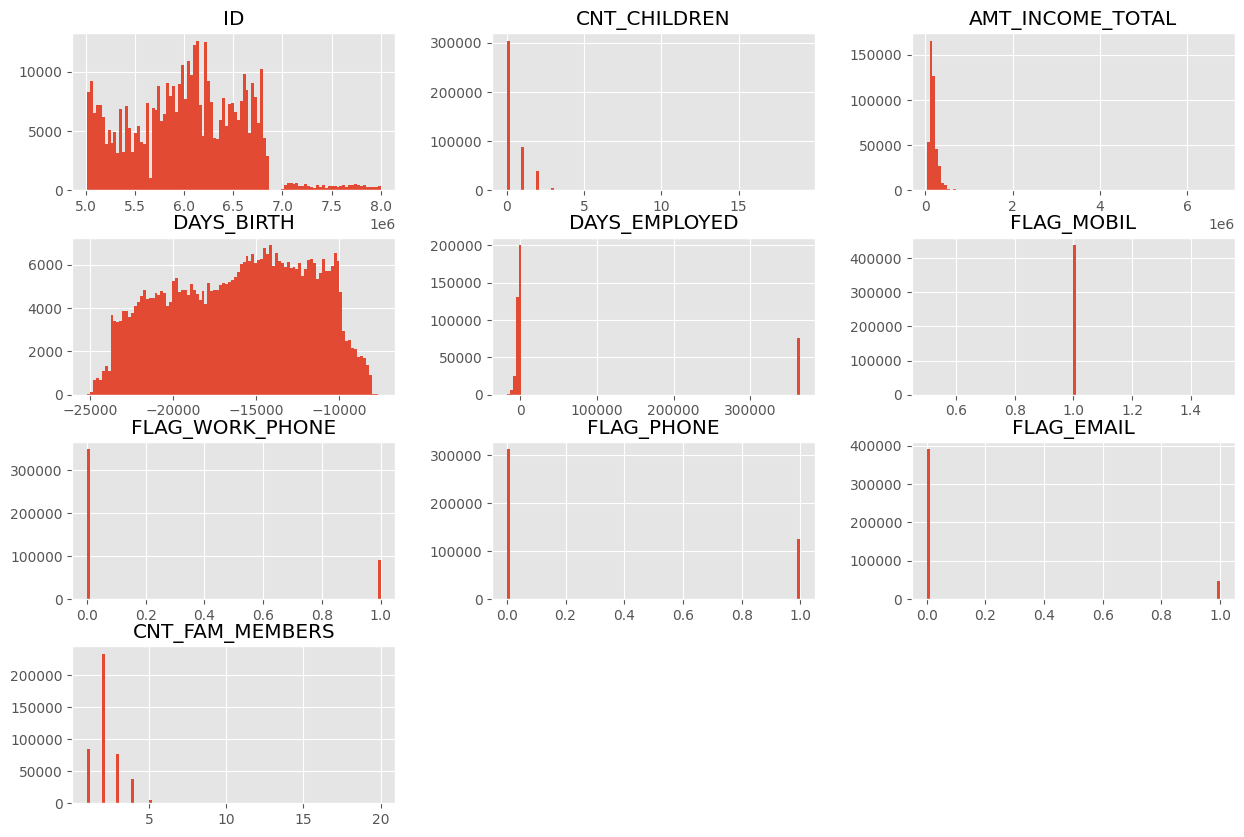

In [706]:
application_records.hist(bins=100,figsize=(15,10))
plt.show()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64


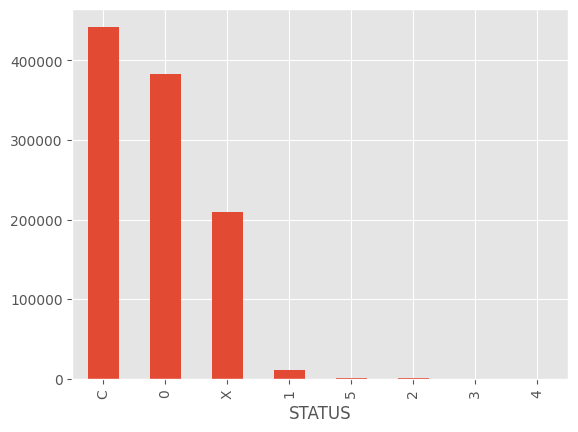

In [707]:
credit_records['STATUS'].value_counts().plot(kind='bar')
print(credit_records['STATUS'].value_counts())

In [708]:
grouped = credit_records.groupby('ID')
pivot_tb = credit_records.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X


In [709]:
credit_records['MONTHS_BALANCE'] = pd.to_numeric(credit_records['MONTHS_BALANCE'],errors='coerce') #set errors to NaN
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min()
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max()
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID','open_month','end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit_records = pd.merge(credit_records, pivot_tb, on = 'ID', how = 'left') # join calculated information, includes end month, open month, and in-between window

In [710]:
#encode target feature
## Target Variable, 'STATUS' column ## (easier to identify overdue payments)

# Simplify the target variable: 1 for overdue payments, 0 for paid off loans
# C means loan is closed or paid off
# X means no loan for the month
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days

In [711]:
 # analyze > 60 days past due, set ones that are past 60 days due to overdue and ones less than that to not due
credit_records['status'] = np.where((credit_records['STATUS'] == '2') | (credit_records['STATUS'] == '3' )| (credit_records['STATUS'] == '4' )| (credit_records['STATUS'] == '5'), 1, 0)
credit_records['status'] = credit_records['status'].astype(int) # 1: overdue 0: not

In [712]:
# calculate month on book: how many months after opening account
credit_records['month_on_book'] = credit_records['MONTHS_BALANCE'] - credit_records['open_month']
credit_records.sort_values(by = ['ID','month_on_book'], inplace = True)

In [713]:
credit_records['application_status'] = credit_records.groupby('ID')['status'].transform('max')
truncate = credit_records.loc[credit_records['application_status']==1]
not_trunc = credit_records.loc[credit_records['application_status']==0]
credit_records

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,status,month_on_book,application_status
3,5001711,-3,0,-3,0,3,0,0,0
2,5001711,-2,0,-3,0,3,0,1,0
1,5001711,-1,0,-3,0,3,0,2,0
0,5001711,0,X,-3,0,3,0,3,0
22,5001712,-18,0,-18,0,18,0,0,0
...,...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25,0
1048548,5150487,-3,C,-29,0,29,0,26,0
1048547,5150487,-2,C,-29,0,29,0,27,0
1048546,5150487,-1,C,-29,0,29,0,28,0


In [714]:
# Assuming not_trunc and truncate are your DataFrames
#not overdue ones
dt1 = not_trunc.groupby('ID').agg({
    'month_on_book': ['max'],
    'application_status': ['max']
})
dt1.reset_index(inplace=True)
dt1.columns = ['ID', 'month_on_book', 'application_status']

#overdue ones
dt2 = truncate.loc[truncate['status'] == 1].groupby('ID').agg({
    'month_on_book': ['min'],
    'application_status': ['max']
})
dt2.reset_index(inplace=True)
dt2.columns = ['ID', 'month_on_book', 'application_status']

# Concatenate dt1 and dt2 vertically
dt = pd.concat([dt1, dt2], ignore_index=True)
dt = pd.merge(dt, application_records, on = 'ID', how = 'left')
dt.fillna('unknown',inplace=True)
pd.options.display.max_rows = 999
dt

/var/folders/z_/9h44s4jd1_v60ytmp987cz8m0000gn/T/ipykernel_42258/963745644.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dt.fillna('unknown',inplace=True)


,ID,month_on_book,application_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5001711,3,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,5001712,18,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
2,5001713,21,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
3,5001714,14,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
4,5001715,59,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5149834,8,1,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0
45981,5149838,8,1,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0
45982,5150049,9,1,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0
45983,5150238,48,1,F,Y,Y,0.0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-19084.0,-128.0,1.0,1.0,0.0,0.0,Laborers,2.0


In [715]:
dt.describe()

,ID,month_on_book,application_status
count,4.598500e+04,45985.000000,45985.000000
mean,5.070164e+06,21.467805,0.014505
std,4.543364e+04,15.400588,0.119560
min,5.001711e+06,0.000000,0.000000
25%,5.026147e+06,9.000000,0.000000
50%,5.065737e+06,18.000000,0.000000
75%,5.114024e+06,32.000000,0.000000
max,5.150487e+06,60.000000,1.000000


In [716]:
merged_data = dt.replace('unknown', np.nan)

/var/folders/z_/9h44s4jd1_v60ytmp987cz8m0000gn/T/ipykernel_42258/3159172707.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data = dt.replace('unknown', np.nan)


In [717]:
merged_data.isna().sum()

ID                         0
month_on_book              0
application_status         0
CODE_GENDER             9528
FLAG_OWN_CAR            9528
FLAG_OWN_REALTY         9528
CNT_CHILDREN            9528
AMT_INCOME_TOTAL        9528
NAME_INCOME_TYPE        9528
NAME_EDUCATION_TYPE     9528
NAME_FAMILY_STATUS      9528
NAME_HOUSING_TYPE       9528
DAYS_BIRTH              9528
DAYS_EMPLOYED           9528
FLAG_MOBIL              9528
FLAG_WORK_PHONE         9528
FLAG_PHONE              9528
FLAG_EMAIL              9528
OCCUPATION_TYPE        20851
CNT_FAM_MEMBERS         9528
dtype: int64

### Check for/ Remove NA Values

In [718]:
merged_data = merged_data.fillna({'OCCUPATION_TYPE': "None"})
merged_data.dropna(inplace=True)


In [719]:
merged_data.isna().sum()

ID                     0
month_on_book          0
application_status     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64

### Feature Encoding/Engineering
CODE_GENDER: 2 categories (no ordinal)

FLAG_OWN_CAR: 2 categories (no ordinal)

FLAG_OWN_REALTY: 2 categories (no ordinal)

NAME_INCOME_TYPE: 5 categories (could have ordering??)

NAME_EDUCATION_TYPE: 5 categories (should have ordering, some more important than others)

NAME_FAMILY_STATUS: 5 categories (could have ordering?)

NAME_HOUSING_TYPE: 6 categories (could have ordering??)

In [720]:
merged_data.head()

,ID,month_on_book,application_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
3215,5008804,15,0,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,None,2.0
3216,5008805,14,0,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,None,2.0
3217,5008806,29,0,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0
3218,5008808,4,0,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0
3219,5008809,4,0,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0


In [721]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 3215 to 45984
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   month_on_book        36457 non-null  int64  
 2   application_status   36457 non-null  int64  
 3   CODE_GENDER          36457 non-null  object 
 4   FLAG_OWN_CAR         36457 non-null  object 
 5   FLAG_OWN_REALTY      36457 non-null  object 
 6   CNT_CHILDREN         36457 non-null  float64
 7   AMT_INCOME_TOTAL     36457 non-null  float64
 8   NAME_INCOME_TYPE     36457 non-null  object 
 9   NAME_EDUCATION_TYPE  36457 non-null  object 
 10  NAME_FAMILY_STATUS   36457 non-null  object 
 11  NAME_HOUSING_TYPE    36457 non-null  object 
 12  DAYS_BIRTH           36457 non-null  float64
 13  DAYS_EMPLOYED        36457 non-null  float64
 14  FLAG_MOBIL           36457 non-null  float64
 15  FLAG_WORK_PHONE      36457 non-null  f

In [722]:
merged_data.shape

(36457, 20)

In [723]:
income_type_order = {
	'Student': 0,
	'Pensioner': 1,
	'State servant': 2,
	'Commercial associate': 3,
	'Working': 4
}
education_type_order = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}
family_status_order = {
	'Single / not married': 0,
	'Separated': 1,
	'Widow': 2,
	'Civil marriage': 3,
	'Married': 4
}
housing_type_order = {
	'Office apartment': 0,
	'With parents': 1,
	'Rented apartment': 2,
	'Municipal apartment': 3,
	'Co-op apartment': 4,
	'House / apartment': 5
}
occupation_type_order = {
	"None":0,
    "Laborers":1,
    "Low-skill Laborers":2,
    "Waiters/barmen staff":3,
    "Cooking staff":4,
    "Private service staff":5,
    "Cleaning staff":6,
    "Drivers":7,
    "Secretaries":8,
    "Security staff":9,
    "Realty agents":10,
    "Sales staff":11,
    "HR staff":12,
    "Core staff":13,
    "Accountants":14,
    "Medicine staff":15,
    "IT staff":16,
    "High skill tech staff":17,
    "Managers":18
}
merged_data['NAME_INCOME_TYPE_ordinal'] = merged_data['NAME_INCOME_TYPE'].map(income_type_order)
merged_data['NAME_EDUCATION_TYPE_ordinal'] = merged_data['NAME_EDUCATION_TYPE'].map(education_type_order) 
merged_data['NAME_FAMILY_STATUS_ordinal'] = merged_data['NAME_FAMILY_STATUS'].map(family_status_order)
merged_data['NAME_HOUSING_TYPE_ordinal'] = merged_data['NAME_HOUSING_TYPE'].map(housing_type_order)
merged_data['OCCUPATION_TYPE_ordinal'] = merged_data['OCCUPATION_TYPE'].map(occupation_type_order)

merged_data.drop(['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'],axis=1,inplace=True)
merged_data.head()

,ID,month_on_book,application_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_ordinal,NAME_EDUCATION_TYPE_ordinal,NAME_FAMILY_STATUS_ordinal,NAME_HOUSING_TYPE_ordinal,OCCUPATION_TYPE_ordinal
3215,5008804,15,0,M,Y,Y,0.0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,2.0,4,3,3,2,0
3216,5008805,14,0,M,Y,Y,0.0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,2.0,4,3,3,2,0
3217,5008806,29,0,M,Y,Y,0.0,112500.0,-21474.0,-1134.0,1.0,0.0,0.0,0.0,2.0,4,1,4,5,9
3218,5008808,4,0,F,N,Y,0.0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,1.0,3,1,0,5,11
3219,5008809,4,0,F,N,Y,0.0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,1.0,3,1,0,5,11


In [724]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 3215 to 45984
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           36457 non-null  int64  
 1   month_on_book                36457 non-null  int64  
 2   application_status           36457 non-null  int64  
 3   CODE_GENDER                  36457 non-null  object 
 4   FLAG_OWN_CAR                 36457 non-null  object 
 5   FLAG_OWN_REALTY              36457 non-null  object 
 6   CNT_CHILDREN                 36457 non-null  float64
 7   AMT_INCOME_TOTAL             36457 non-null  float64
 8   DAYS_BIRTH                   36457 non-null  float64
 9   DAYS_EMPLOYED                36457 non-null  float64
 10  FLAG_MOBIL                   36457 non-null  float64
 11  FLAG_WORK_PHONE              36457 non-null  float64
 12  FLAG_PHONE                   36457 non-null  float64
 13  FLAG_EMAIL        

In [725]:
#change all categories with only two categories to 0s and 1s
le = LabelEncoder()
two_categories_cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']
for col in two_categories_cols:
	merged_data[col] = le.fit_transform(merged_data[col])
merged_data.head()

#option 1: try one hot encoding for remaining features
#one_hot_cols = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']
#merged_data = pd.get_dummies(merged_data,columns=one_hot_cols,dtype=int)

#option 2: try binary encoding
#binary_encode_cols = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']
#encoder = BinaryEncoder(cols = binary_encode_cols,return_df=True)
#merged_data = encoder.fit_transform(merged_data)		

,ID,month_on_book,application_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_ordinal,NAME_EDUCATION_TYPE_ordinal,NAME_FAMILY_STATUS_ordinal,NAME_HOUSING_TYPE_ordinal,OCCUPATION_TYPE_ordinal
3215,5008804,15,0,1,1,1,0.0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,2.0,4,3,3,2,0
3216,5008805,14,0,1,1,1,0.0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,2.0,4,3,3,2,0
3217,5008806,29,0,1,1,1,0.0,112500.0,-21474.0,-1134.0,1.0,0.0,0.0,0.0,2.0,4,1,4,5,9
3218,5008808,4,0,0,0,1,0.0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,1.0,3,1,0,5,11
3219,5008809,4,0,0,0,1,0.0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,1.0,3,1,0,5,11


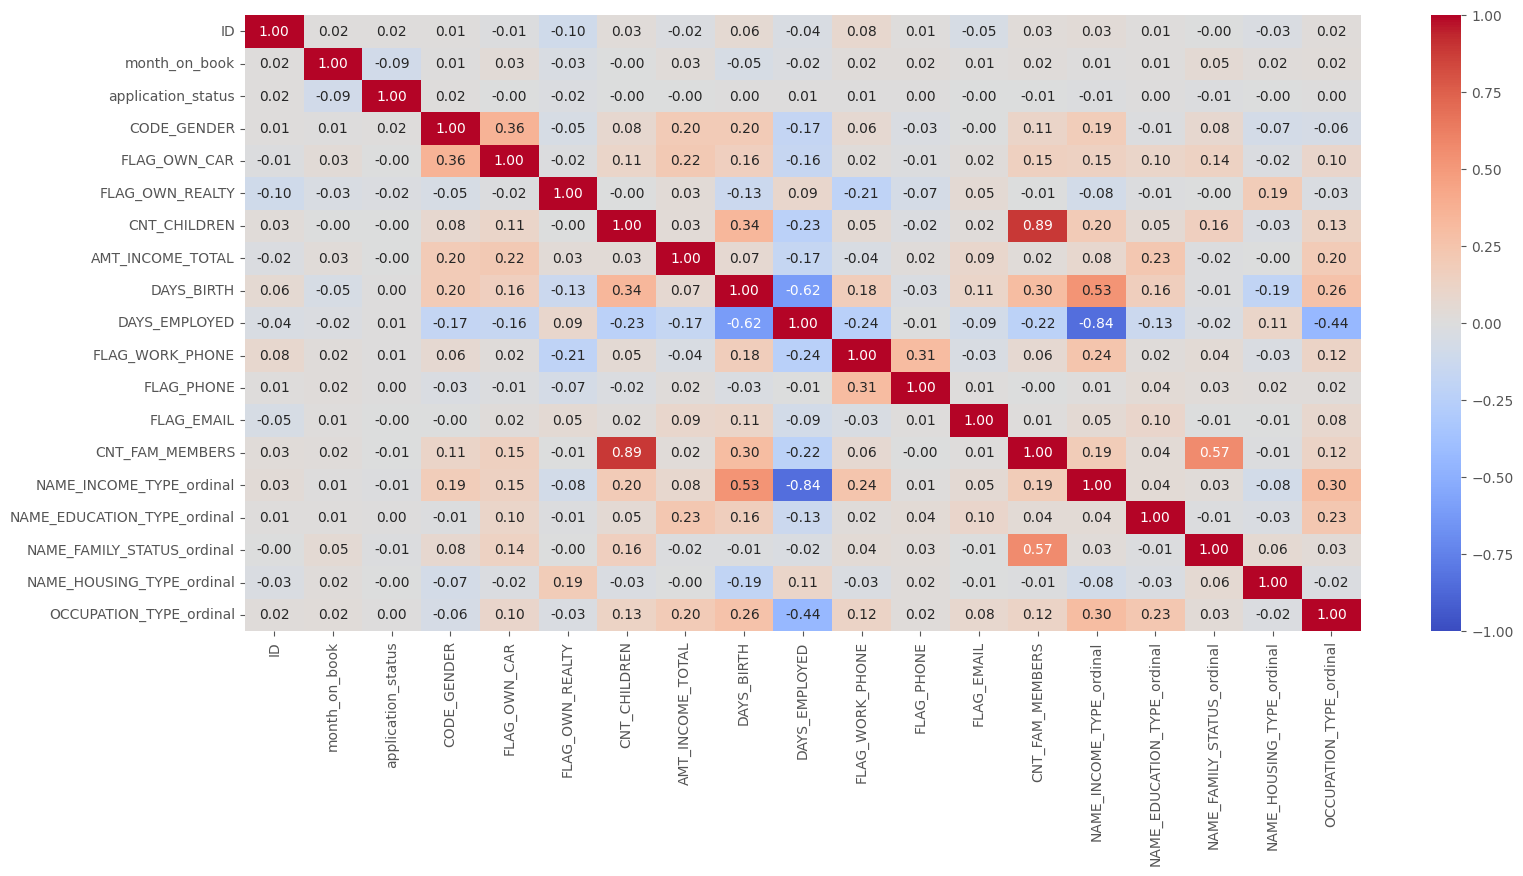

In [726]:
plt.figure(figsize=(18,8))
corr_matrix = merged_data.drop(['FLAG_MOBIL'],axis=1).corr()
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt=".2f",vmin=-1,center=0)
plt.show()

### Modeling

In [727]:
merged_data = merged_data.drop(['month_on_book','FLAG_MOBIL','ID'],axis=1)

In [728]:
X = merged_data.drop(['application_status'],axis=1)
features = X.columns
y = merged_data['application_status']

In [729]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 3215 to 45984
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   application_status           36457 non-null  int64  
 1   CODE_GENDER                  36457 non-null  int64  
 2   FLAG_OWN_CAR                 36457 non-null  int64  
 3   FLAG_OWN_REALTY              36457 non-null  int64  
 4   CNT_CHILDREN                 36457 non-null  float64
 5   AMT_INCOME_TOTAL             36457 non-null  float64
 6   DAYS_BIRTH                   36457 non-null  float64
 7   DAYS_EMPLOYED                36457 non-null  float64
 8   FLAG_WORK_PHONE              36457 non-null  float64
 9   FLAG_PHONE                   36457 non-null  float64
 10  FLAG_EMAIL                   36457 non-null  float64
 11  CNT_FAM_MEMBERS              36457 non-null  float64
 12  NAME_INCOME_TYPE_ordinal     36457 non-null  int64  
 13  NAME_EDUCATION_TYP

In [730]:
from sklearn.utils import resample

In [731]:
len(X_balanced)

71682

In [732]:
# Create a balanced dataset by oversampling the minority class
X_resampled, y_resampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

# Concatenate the resampled data with the majority class
X_balanced = pd.concat([X[y == 0], X_resampled])
y_balanced = pd.concat([y[y == 0], y_resampled])

In [733]:
## Logistic Model ##
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

ct = make_column_transformer(
	#(StandardScaler(),features),
    (MinMaxScaler(),features),
    remainder='passthrough'
	)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [734]:
merged_data['application_status'].value_counts()

application_status
0    35841
1      616
Name: count, dtype: int64

Accuracy: 0.5573690451279905
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      7210
           1       0.56      0.54      0.55      7127

    accuracy                           0.56     14337
   macro avg       0.56      0.56      0.56     14337
weighted avg       0.56      0.56      0.56     14337



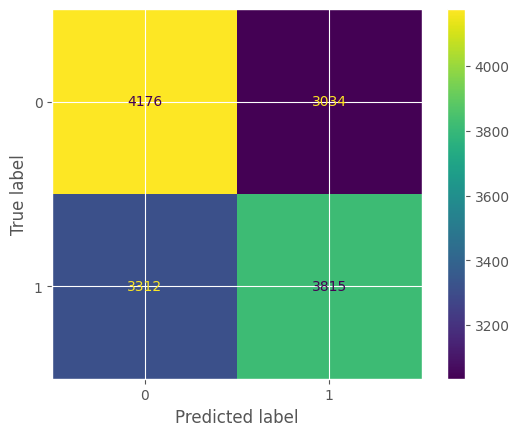

In [630]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix)
disp.plot()


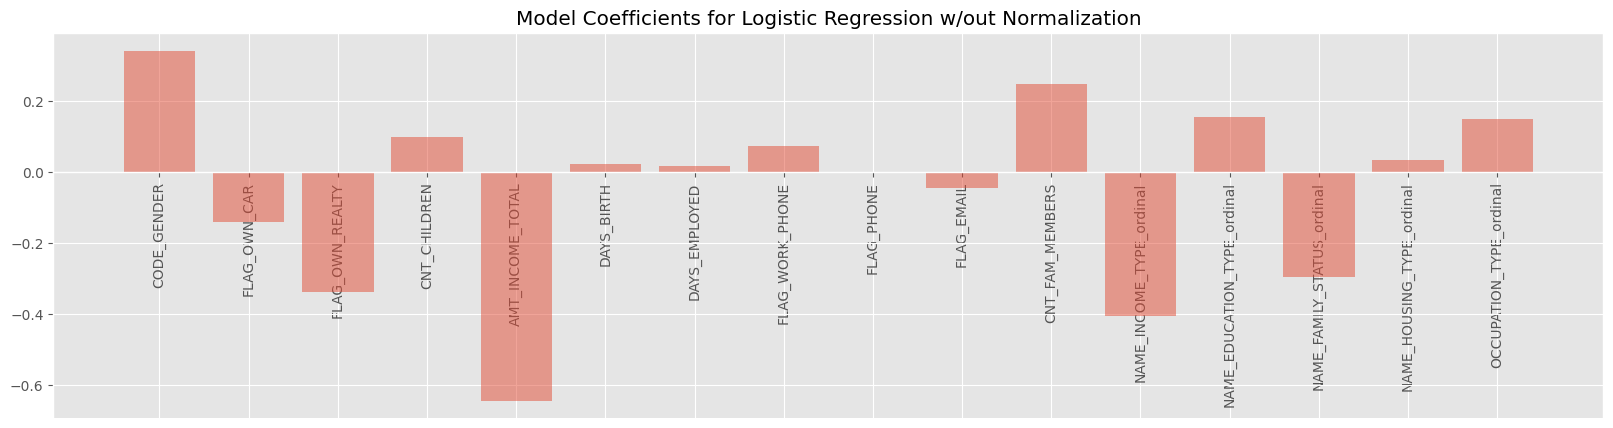

In [745]:
def graph_coefficients(model,model_name,features):
	lreg_coefficients = pd.DataFrame()
	lreg_coefficients['Columns'] = features
	lreg_coefficients['Coefficient Estimate'] = pd.Series(model.coef_[0])
	fig, ax = plt.subplots(figsize=(20, 5))
	ax.bar(lreg_coefficients["Columns"], lreg_coefficients['Coefficient Estimate'],alpha=0.5)

	ax.spines['bottom'].set_position('zero')
	plt.xticks(rotation=90)
	plt.title(f"Model Coefficients for {model_name} w/out Normalization")
	plt.style.use('ggplot')
	plt.show()
graph_coefficients(logreg,"Logistic Regression",features=features)

In [632]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import time
import sklearn
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, precision_recall_curve, roc_auc_score, roc_curve,f1_score


In [633]:
def plot_precision_recall(y_test,y_pred):
	precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
	fpr, tpr, thresholds = roc_curve(y_test, y_pred)

	fig,ax = plt.subplots(1,2,figsize=(20,4))
	ax[0].plot(recall, precision, color='green')
	ax[0].set_title('Precision-Recall Curve')
	ax[0].set_ylabel('Precision')
	ax[0].set_xlabel('Recall')

	ax[1].plot(fpr, tpr)
	ax[1].set_xlabel('False Positive Rate')
	ax[1].set_ylabel('True Positive Rate')
	ax[1].set_title(f'AUC Score: {roc_auc_score(y_test,y_pred):.6f}')

	plt.show()

In [634]:
classifier_dict = dict()
def display_metrics(classifier,classifiername,y_train,y_train_pred,y_test,y_test_pred,time=float('NaN'),cnf=False,classreport=False,prec_recall=False):
	
	if (classifiername in classifier_dict.keys()):
		train_accuracy = classifier_dict[classifiername][1]
		test_accuracy = classifier_dict[classifiername][2]
		f1_score = classifier_dict[classifiername][3]
		train_time = classifier_dict[classifiername][4]
	else:
		train_accuracy = accuracy_score(y_train,y_train_pred)
		test_accuracy = accuracy_score(y_test,y_test_pred)
		f1_score = sklearn.metrics.f1_score(y_test,y_test_pred)
		train_time = time
		classifier_dict[classifiername] = [classifier,train_accuracy,test_accuracy,f1_score,train_time]
	
	print(f"Train Accuracy: {train_accuracy:.4f}, " 
			f"Test Accuracy: {test_accuracy:.4f}, " 
			f"F1-score: {f1_score:.4f}, " 
			f"Train Time: {train_time:.4f} seconds\n")

	if (classreport):
		print("Classification Report:")
		print(classification_report(y_test,y_test_pred))

	if (cnf):
		cnf_matrix = confusion_matrix(y_test,y_test_pred)
		disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix)
		disp.plot()
		
	if (prec_recall):
		plot_precision_recall(y_test,y_test_pred)

	if(any(set((cnf,classreport,prec_recall)))):
		plt.show() 	
		plt.tight_layout()

In [635]:
#create all models i want to test
random_state = 21
classifier_models = [
	LogisticRegression(random_state=random_state),
	RandomForestClassifier(random_state=random_state),
	DecisionTreeClassifier(random_state=random_state),
    #ExtraTreesClassifier(random_state=random_state),
    #GradientBoostingClassifier(random_state=random_state),
	XGBClassifier(),
	LGBMClassifier()
]
classifier_names = [
	"LogisticRegression",
	"RandomForestClassifier",
	"DecisionTreeClassifier",
	#"ExtraTrees",
    #"GradientBoosting",
	"XGBoost",
	"LGBM"
]
classifiers = dict(zip(classifier_names,classifier_models))
fitted_models = {}

In [636]:
# to run through all possible models
for clf_name, clf_model in classifiers.items():
    if (clf_name in classifier_dict.keys()):
        print(f"Report for {clf_model}:")
        display_metrics(clf_model,clf_name,y_train,y_train_pred,y_test,y_test_pred,time=end-start)
    else:
        start = time.time()
        clf_model.fit(X_train,y_train)
        end = time.time()
        fitted_models[clf_name] = clf_model
        y_train_pred = clf_model.predict(X_train)
        y_test_pred = clf_model.predict(X_test)
        print(f"Report for {clf_model}:")
        display_metrics(clf_model,clf_name,y_train,y_train_pred,y_test,y_test_pred,time=end-start)

Report for LogisticRegression(random_state=21):
Train Accuracy: 0.5535, Test Accuracy: 0.5574, F1-score: 0.5459, Train Time: 0.3672 seconds

Report for RandomForestClassifier(random_state=21):
Train Accuracy: 0.9840, Test Accuracy: 0.9833, F1-score: 0.9835, Train Time: 4.4326 seconds

Report for DecisionTreeClassifier(random_state=21):
Train Accuracy: 0.9840, Test Accuracy: 0.9814, F1-score: 0.9817, Train Time: 0.1813 seconds

Report for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
      

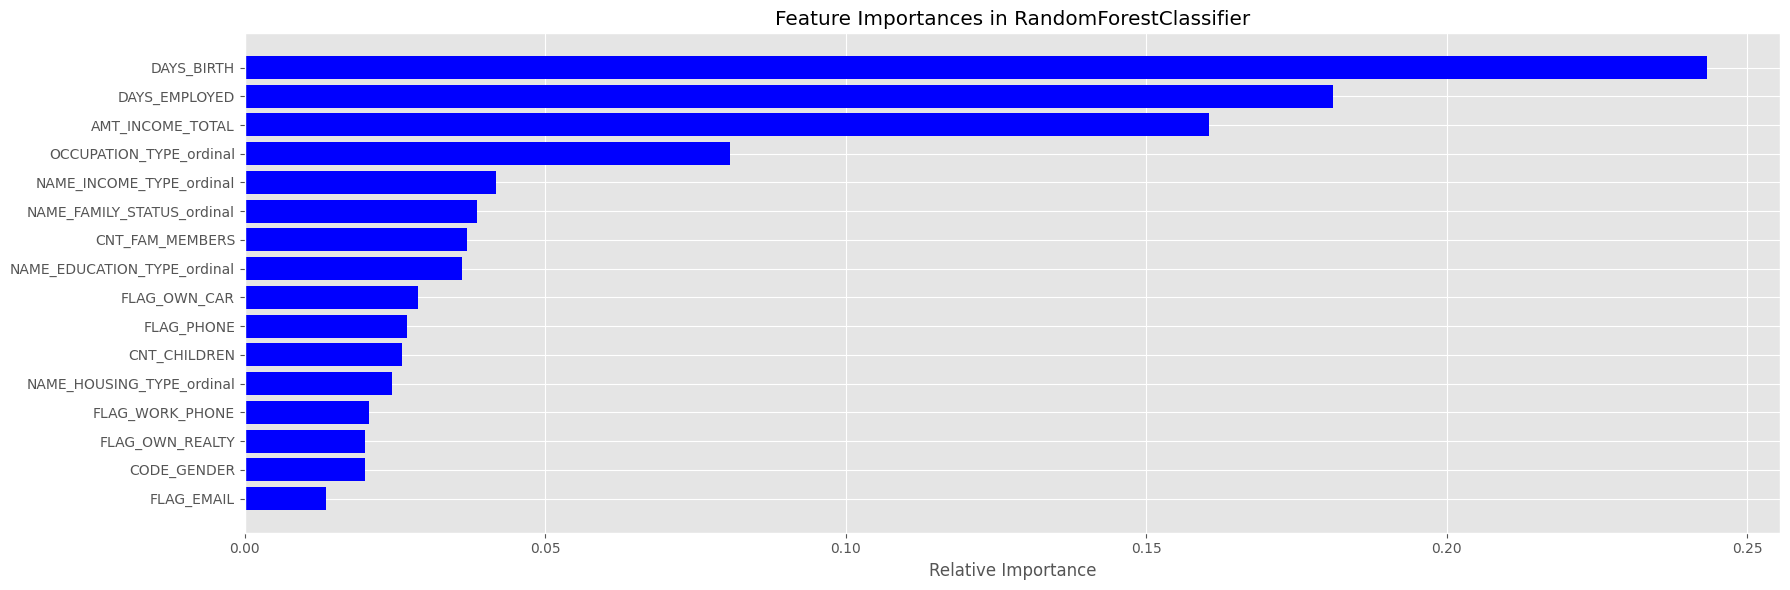

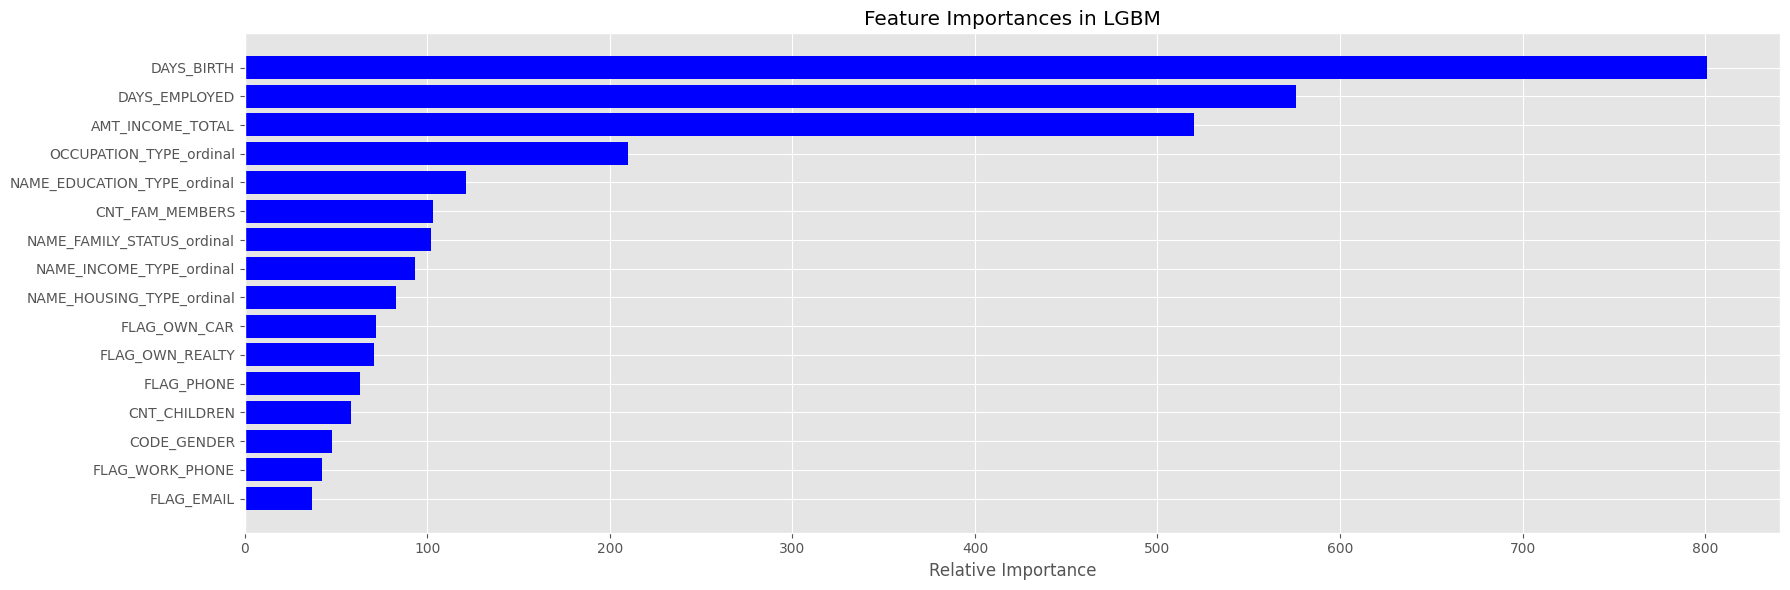

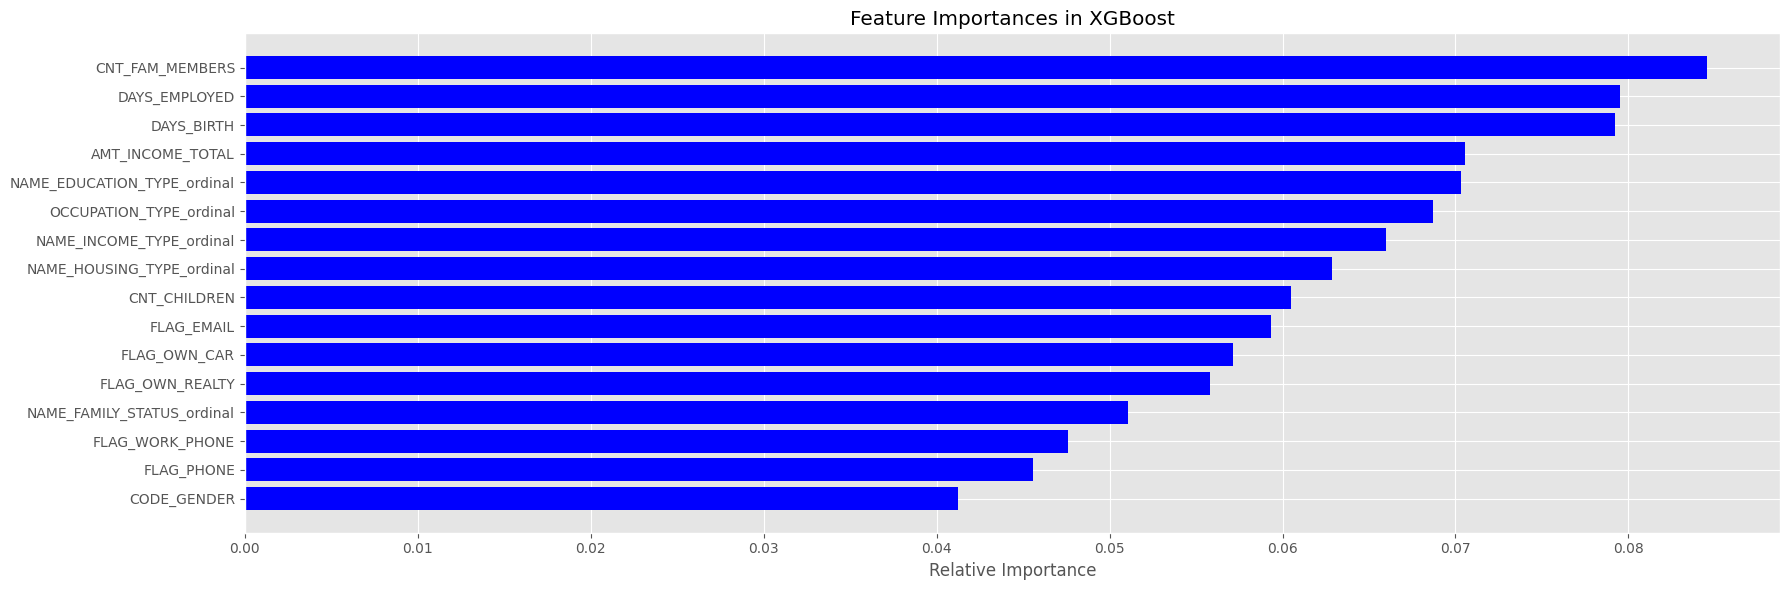

In [638]:
#plot the feature importances for each model that includes this possibility
def plot_feature_importance(fitted_models,classifiers):
	for classifier in classifiers:
		model = fitted_models[classifier]
		importances = model.feature_importances_
		indices = np.argsort(importances)
		plt.figure(figsize=(18, 6))
		plt.title(f'Feature Importances in {classifier}')
		plt.barh(range(len(indices)), importances[indices], color='b', align='center')
		plt.yticks(range(len(indices)), [features[i] for i in indices])
		plt.xlabel('Relative Importance')
		plt.tight_layout()
		plt.show()
plot_feature_importance(fitted_models=fitted_models,classifiers=['RandomForestClassifier','LGBM','XGBoost'])

In [644]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


In [643]:
# Defining the neural network model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/50
1434/1434 [==============================] - 2s 980us/step - loss: 0.6581 - accuracy: 0.6043 - val_loss: 0.6097 - val_accuracy: 0.6532
Epoch 2/50
1434/1434 [==============================] - 1s 935us/step - loss: 0.5513 - accuracy: 0.7090 - val_loss: 0.4960 - val_accuracy: 0.7521
Epoch 3/50
1434/1434 [==============================] - 1s 886us/step - loss: 0.4598 - accuracy: 0.7748 - val_loss: 0.4394 - val_accuracy: 0.7941
Epoch 4/50
1434/1434 [==============================] - 1s 972us/step - loss: 0.4029 - accuracy: 0.8113 - val_loss: 0.4107 - val_accuracy: 0.8073
Epoch 5/50
1434/1434 [==============================] - 1s 976us/step - loss: 0.3644 - accuracy: 0.8343 - val_loss: 0.3839 - val_accuracy: 0.8146
Epoch 6/50
1434/1434 [==============================] - 1s 877us/step - loss: 0.3330 - accuracy: 0.8544 - val_loss: 0.3354 - val_accuracy: 0.8465
Epoch 7/50
1434/1434 [==============================] - 1s 883us/step - loss: 0.3143 - accuracy: 0.8627 - val_loss: 0.3217 -

In [739]:
num_val = int(0.1*len(X_train))
X_train_nn,X_val_nn = X_train[:-num_val],X_train[-num_val:]
y_train_nn,y_val_nn = y_train[:-num_val],y_train[-num_val:]

In [740]:
#creating the Neural Network
nn_model = Sequential([
	Dense(128,activation='relu'),
	Dense(128,activation='relu'),
	Dense(1,activation='sigmoid')
])
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = EarlyStopping(
	monitor = 'val_loss',
	mode='auto',
    patience=5,
    restore_best_weights=True,
)
start = time.time()
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val_nn, y_val_nn),
    batch_size=32,
    epochs=25,
    callbacks=[early_stopping],
)
end = time.time()

Epoch 1/25
1793/1793 [==============================] - 2s 877us/step - loss: 0.6307 - binary_accuracy: 0.6307 - val_loss: 0.5710 - val_binary_accuracy: 0.6884
Epoch 2/25
1793/1793 [==============================] - 2s 878us/step - loss: 0.5211 - binary_accuracy: 0.7339 - val_loss: 0.4770 - val_binary_accuracy: 0.7747
Epoch 3/25
1793/1793 [==============================] - 1s 797us/step - loss: 0.4417 - binary_accuracy: 0.7878 - val_loss: 0.4250 - val_binary_accuracy: 0.8001
Epoch 4/25
1793/1793 [==============================] - 1s 802us/step - loss: 0.3871 - binary_accuracy: 0.8238 - val_loss: 0.3644 - val_binary_accuracy: 0.8328
Epoch 5/25
1793/1793 [==============================] - 2s 866us/step - loss: 0.3418 - binary_accuracy: 0.8489 - val_loss: 0.3299 - val_binary_accuracy: 0.8530
Epoch 6/25
1793/1793 [==============================] - 1s 829us/step - loss: 0.3116 - binary_accuracy: 0.8693 - val_loss: 0.2882 - val_binary_accuracy: 0.8845
Epoch 7/25
1793/1793 [==================

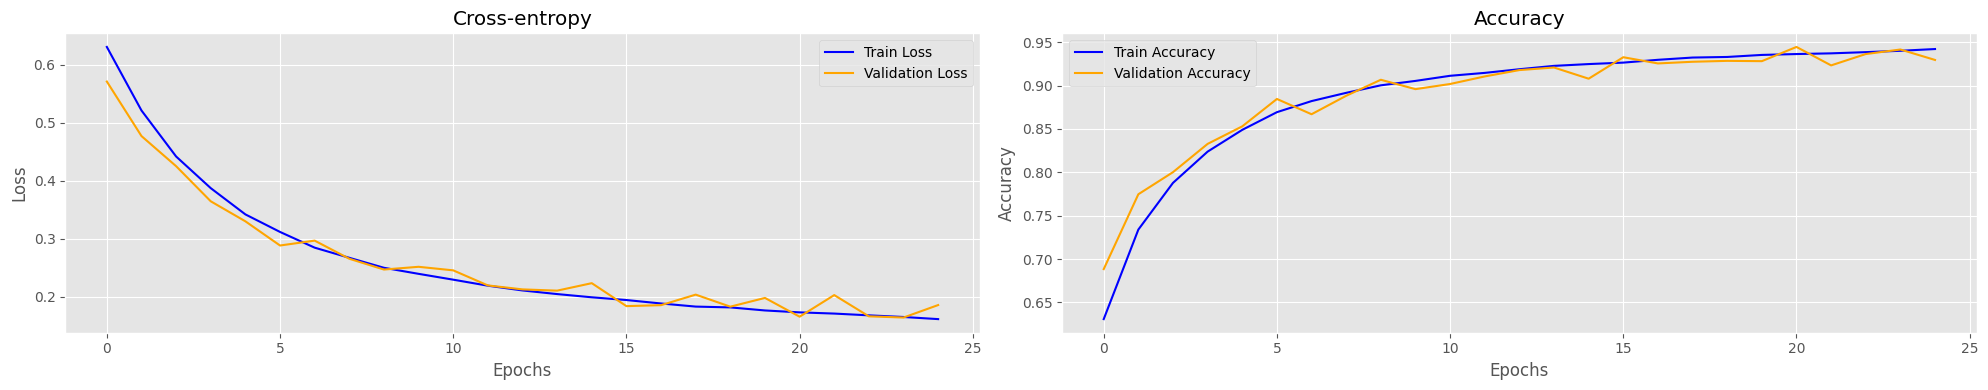

In [741]:
history_df = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

# Plot the cross-entropy loss on the first subplot
ax1.plot(history_df['loss'], label='Train Loss', color='blue')
ax1.plot(history_df['val_loss'], label='Validation Loss', color='orange')
ax1.set_title('Cross-entropy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()  # This will use the labels specified in the `plot` calls

# Plot the accuracy on the second subplot
ax2.plot(history_df['binary_accuracy'], label='Train Accuracy', color='blue')
ax2.plot(history_df['val_binary_accuracy'], label='Validation Accuracy', color='orange')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()  # This will use the labels specified in the `plot` calls

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [744]:
train_score = nn_model.evaluate(X_train_nn,y_train_nn)[1]
test_score = nn_model.evaluate(X_test,y_test)[1]
y_pred = nn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to 1-D array if necessary
f1 = f1_score(y_test, y_pred_classes, average='weighted')  # Use 'micro', 'macro', or 'binary' as needed
classifier_dict['Neural Network'] = ["Neural Network",train_score,test_score,f1,end-start]
print(f"Train accuracy: {train_score}")
print(f"Test Accuracy: {test_score}")

449/449 [==============================] - 0s 428us/step
Train accuracy: 0.9358857870101929
Test Accuracy: 0.9291344285011292


In [746]:
os.getcwd()

'/Users/kevingui/Documents/UCD/ecs111/project/CreditCardApproval'

In [747]:
nn_model.save(os.getcwd())

INFO:tensorflow:Assets written to: /Users/kevingui/Documents/UCD/ecs111/project/CreditCardApproval/assets


INFO:tensorflow:Assets written to: /Users/kevingui/Documents/UCD/ecs111/project/CreditCardApproval/assets
